In [1]:
import spacy
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
from itertools import chain
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

plt.rcParams['font.family'] = 'serif'

import seaborn as sns
sns.set_theme(palette="pastel", style="white")

In [2]:
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_trf

2023-08-17 01:30:55.471460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
%pip install pyarrow

import pyarrow as pa
import pyarrow.parquet as pq

In [4]:
# ner = spacy.load("en_core_web_sm")
# ner = spacy.load("en_core_web_md")
ner = spacy.load("en_core_web_lg")
# ner = spacy.load("en_core_web_trf")

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
output_file_parquet = pq.read_table('/content/gdrive/MyDrive/Colab dataset/df_vader.parquet')
df_relevant_articles = output_file_parquet.to_pandas()

sample_df = df_relevant_articles.sample(frac=0.7, replace=False, random_state=1)

sample_df.head()

,date,processed_text,sentiment_vader
6543,2023-05-26,iccsd leveraging power ai sustainable developm...,positive
101133,2023-04-10,university houston using artificial intelligen...,positive
78328,2020-07-11,transform 2020 4 day deepdive ai learning vent...,positive
17117,2023-05-31,china warns artificial intelligence risk call ...,positive
16537,2020-03-05,philip launch healthsuite system engagement ne...,positive


In [7]:
def extract_entities(text):
    doc = ner(text, disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
    people = set()
    organizations = set()
    products = set()
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            people.add(ent.text.upper())
        elif ent.label_ == 'ORG':
            organizations.add(ent.text.upper())
        elif ent.label_ == 'PRODUCT':
            products.add(ent.text.upper())
    return list(people), list(organizations), list(products)


In [8]:
#sample_df = sample_df.head(100)
sample_df[['people', 'organizations', 'products']] = sample_df['processed_text'].apply(extract_entities).apply(pd.Series)

In [9]:
sample_df

,date,processed_text,sentiment_vader,people,organizations,products
6543,2023-05-26,iccsd leveraging power ai sustainable developm...,positive,"[APPCLOSINGSSTORIESMAPSFIRST, ZHIQIANG, BARICC...","[CONTESTSTATS, WEBWSAWCOM, UNESCO, QUALITYCOMM...",[]
101133,2023-04-10,university houston using artificial intelligen...,positive,[RESULTSCONSUMERHEALTHPOLITICSSEEN TVDAILY NEW...,"[WEATHERFOX SOULCALL KAT KITTEN, TRIPSTHEME PA...",[]
78328,2020-07-11,transform 2020 4 day deepdive ai learning vent...,positive,"[U FLIPBOARD, KYLE, U INSTAGRAM, PROBEAT]","[BIG DATA BUSINESS CLOUD COMMERCE, DEEPDIVE AI...",[VENTUREBEATS]
17117,2023-05-31,china warns artificial intelligence risk call ...,positive,"[SEAN DIDDY, AP, NFL LIV, NEWTON, DANNY MASTER...","[NEXSTAR MEDIUM INC RIGHT, GULF COAST, ALABAMA...","[TSA PRECHECK, GOOGLE]"
16537,2020-03-05,philip launch healthsuite system engagement ne...,positive,"[PHILIP HEALTHSUITE, SUPERNEWS ACME, SUDAN MAR...","[AEX, SIOMAI ALBAY TOWNPALACE, HEALTHSUITE, PH...",[]
...,...,...,...,...,...,...
64232,2022-10-11,numberone ai launch mission change incubator g...,positive,"[20220908AM, MICHAEL CAPELLA, STANDARDSPRINTRE...","[MCAFEE 2004, NUMBERONE, GAMETONY BRADLEYSENIO...","[M2OCT, CYLANCE]"
65428,2023-04-12,expedia app integrates chatgpt expedia app int...,positive,"[CHRISTOF STACHEAFP, HEREMORE, 20231013AM EDTW...","[EXPEDIA APP, LUFTHANSA LAND MUNICH INTERNATIO...",[CHATBOT]
70435,2022-06-27,opinion artificial intelligence keeping world ...,positive,"[KAREN TUMULTY, STEPHEN STROMBERG, JONATHAN CA...","[MARCUS, STATEMENTSKIP, GOOPINIONMAY, EDUCATIO...",[]
77688,2023-06-06,imki enhances brand heritage creating custom g...,positive,"[DRIVERENO, BREAKNATIONALPOLITICSRELIGIONSAFET...","[GPT, SERVICEPRIVACY POLICYEEO STATEMENTADVERT...",[]


In [10]:
# Flatten the lists in 'people', 'organizations', and 'products' columns
people_flat = [person for sublist in sample_df['people'] for person in sublist]
organization_flat = [org for sublist in sample_df['organizations'] for org in sublist]
product_flat = [prod for sublist in sample_df['products'] for prod in sublist]

# Count the occurrences of people, organizations, and products
people_counts = pd.Series(people_flat).value_counts()
organization_counts = pd.Series(organization_flat).value_counts()
product_counts = pd.Series(product_flat).value_counts()

# Create DataFrames to store the counts
people_df = pd.DataFrame({'person': people_counts.index, 'count': people_counts.values})
organization_df = pd.DataFrame({'organization': organization_counts.index, 'count': organization_counts.values})
product_df = pd.DataFrame({'product': product_counts.index, 'count': product_counts.values})

In [11]:
not_peo = ['CAPTIONINGAUDIO DESCRIPTIONA GRAY MEDIUM GROUP INC', 'GRETA VAN SUSTERENCIRCLE - COUNTRY','YOU.S.',
           'PORTER','BING','SIZE','DANMARK DEUTSCHLAND ESPA', 'GRETA VAN SUSTERENCIRCLE COUNTRY',
           'INSTAGRAM','SU TIERRA TIEMPO','COSTELLO','PM EDT|UPDATED','YOU.S.A. PHONE NO','BARD','JUN',
           'GRETA VAN SUSTERENGRAY DC', 'MD', 'WIE BEWERTEN SIE','BEWERTEN','KOSTENLOSE VON UND FNRD-',
           'NEWSUP', 'FORBES', 'RISIKEN', 'DEEP', 'WIR EMPFEHLEN INTERESSENTEN UND POTENZIELLEN ANLEGERN DEN BASISPROSPEKT',
           'WERTPAPIERE ZU VERSTEHEN', 'BEVOR SIE EINE TREFFEN', 'VERSTEHEN SEIN KANN', 'MAX', 'GB',
           'TVLATEST NEWSCASTSPRESS', 'HEREMORE', 'PRODUCT HUNT', 'R GDPR', 'NORGE POLSKA', 'BUREAUINVESTIGATE', 'INFOHELP', 'RICO QATAR']
not_org = ['AI','ARTIFICIAL INTELLIGENCE','GLOBALLY ARTIFICIAL INTELLIGENCE','GRAY MEDIA GROUP',
           'MACHINE LEARNING','ML','BARD','COMPANY', 'STATE', 'SERVICEPRIVACY POLICYEEO GRAY MEDIA GROUP',
           'FACEBOOK SHARE','REUTERS','WORDPRESS | THEME','SERVICEPRIVACY POLICYEEO STATEMENTFCC GRAY MEDIA GROUP',
           'LLC','SERVICEPRIVACY POLICYEEO DESCRIPTIONA GRAY MEDIA GROUP','POLLS AND','THE ASSOCIATED PRESS',
           'GLOBAL ARTIFICIAL INTELLIGENCE','THE ARTIFICIAL INTELLIGENCE','THE ASSOCIATED PRESS',
           'ASSOCIATED PRESS','AP', '20022022 GRAY TELEVISION INC', '20022023 GRAY TELEVISION INC', 'FCC', 'MUSIC LIFESTYLEGRAY DC', 'UNITED STATE']

# Filtering the DataFrame
people_df = people_df[~people_df.isin(not_peo)].dropna(how='any')
organization_df = organization_df[~organization_df.isin(not_org)].dropna(how='any')

In [12]:
people_df['person']

1                      SAM ALTMAN
4                           BIDEN
6                       JOE BIDEN
7                    DONALD TRUMP
9                 MONACO MONGOLIA
                   ...           
267296        AIWHILE SELFDRIVING
267297                HOMESTHANKS
267298    LIBRARYGETTY IMAGESWHEN
267299                     BRENNA
267300                    BARIMKI
Name: person, Length: 267281, dtype: object

In [13]:
# Filter the DataFrame based on the 25th percentile
people_df = people_df[people_df['count'] > np.percentile(people_df['count'], 25)]
organization_df = organization_df[organization_df['count'] > np.percentile(organization_df['count'], 25)]
product_df = product_df[product_df['count'] > np.percentile(product_df['count'], 25)]

# Ignore entries with counts less than 100 times
entity_threshold = 100
people_df = people_df[people_df['count'] >= entity_threshold]
organization_df = organization_df[organization_df['count'] >= entity_threshold]
product_df = product_df[product_df['count'] >= entity_threshold]

In [14]:
# Sort the counts DataFrame in descending order based on count values
people_df = people_df.sort_values(by=['count','person'], ascending=[False,True], ignore_index=True)
organization_df = organization_df.sort_values(by=['count','organization'], ascending=[False,True], ignore_index=True)
product_df = product_df.sort_values(by=['count','product'], ascending=[False,True], ignore_index=True)

# Convert the relevant counts DataFrame columns to sets
most_mentioned_people = set(people_df['person'])
most_mentioned_organizations = set(organization_df['organization'])
most_mentioned_products = set(product_df['product'])

In [15]:
people_df.head(10)

,person,count
0,SAM ALTMAN,2502
1,BIDEN,1842
2,JOE BIDEN,1533
3,DONALD TRUMP,1314
4,MONACO MONGOLIA,999
5,VERDE CAYMAN,984
6,U PERU,935
7,COMOROS CONGOBRAZZAVILLE CONGOKINSHASA,934
8,GREECE GUAM GUATEMALA,934
9,JORDAN KANSA,934


In [16]:
organization_df.head(10)

,organization,count
0,CHATGPT,15580
1,MICROSOFT,7490
2,IBM,6507
3,ANDROID,6031
4,GOOGLE,5133
5,FDA,3903
6,CONGRESS,3541
7,DATADRIVEN,3149
8,NEXSTAR MEDIUM INC RIGHT,2791
9,U STATE,2719


In [17]:
product_df.head(10)

,product,count
0,GOOGLE,9100
1,AIDRIVEN,3269
2,VOIP,2464
3,VKONTAKTE,1166
4,ACCUWEATHER,718
5,SAAS,658
6,NVIDIA,564
7,GMT,516
8,ML,407
9,BMW,396


In [18]:
# Clean the 'people' column to include only the most mentioned people
sample_df['top_peo'] = sample_df['people'].apply(lambda x: [person for person in x if person in most_mentioned_people])

# Clean the 'organizations' column to include only the most mentioned organizations
sample_df['top_org'] = sample_df['organizations'].apply(lambda x: [org for org in x if org in most_mentioned_organizations])

# Clean the 'products' column to include only the most mentioned products
sample_df['top_prod'] = sample_df['products'].apply(lambda x: [prod for prod in x if prod in most_mentioned_products])

In [19]:
sample_df

,date,processed_text,sentiment_vader,people,organizations,products,top_peo,top_org,top_prod
6543,2023-05-26,iccsd leveraging power ai sustainable developm...,positive,"[APPCLOSINGSSTORIESMAPSFIRST, ZHIQIANG, BARICC...","[CONTESTSTATS, WEBWSAWCOM, UNESCO, QUALITYCOMM...",[],"[APPCLOSINGSSTORIESMAPSFIRST, PROJECTCOVID19 I...","[WEBWSAWCOM, UNESCO, PHOTOSSKI, UN, AVEWAUSAU,...",[]
101133,2023-04-10,university houston using artificial intelligen...,positive,[RESULTSCONSUMERHEALTHPOLITICSSEEN TVDAILY NEW...,"[WEATHERFOX SOULCALL KAT KITTEN, TRIPSTHEME PA...",[],"[OPENAIS CHATGPT, BIDEN]","[NSF, NFT]",[]
78328,2020-07-11,transform 2020 4 day deepdive ai learning vent...,positive,"[U FLIPBOARD, KYLE, U INSTAGRAM, PROBEAT]","[BIG DATA BUSINESS CLOUD COMMERCE, DEEPDIVE AI...",[VENTUREBEATS],[U INSTAGRAM],"[MICROSOFT, VENTUREBEAT COMMUNITY]",[VENTUREBEATS]
17117,2023-05-31,china warns artificial intelligence risk call ...,positive,"[SEAN DIDDY, AP, NFL LIV, NEWTON, DANNY MASTER...","[NEXSTAR MEDIUM INC RIGHT, GULF COAST, ALABAMA...","[TSA PRECHECK, GOOGLE]","[AP, LEE, INPERSON, JOHN, XI JINPING, SIXMONTH]","[NEXSTAR MEDIUM INC RIGHT, HILL NEWSNATION BES...",[GOOGLE]
16537,2020-03-05,philip launch healthsuite system engagement ne...,positive,"[PHILIP HEALTHSUITE, SUPERNEWS ACME, SUDAN MAR...","[AEX, SIOMAI ALBAY TOWNPALACE, HEALTHSUITE, PH...",[],[SUPERNEWS ACME],"[PHILIP, HEALTHCARE]",[]
...,...,...,...,...,...,...,...,...,...
64232,2022-10-11,numberone ai launch mission change incubator g...,positive,"[20220908AM, MICHAEL CAPELLA, STANDARDSPRINTRE...","[MCAFEE 2004, NUMBERONE, GAMETONY BRADLEYSENIO...","[M2OCT, CYLANCE]",[],[PIONEER],[]
65428,2023-04-12,expedia app integrates chatgpt expedia app int...,positive,"[CHRISTOF STACHEAFP, HEREMORE, 20231013AM EDTW...","[EXPEDIA APP, LUFTHANSA LAND MUNICH INTERNATIO...",[CHATBOT],[],"[ANDROID, AIRBUS, CHATGPT]",[]
70435,2022-06-27,opinion artificial intelligence keeping world ...,positive,"[KAREN TUMULTY, STEPHEN STROMBERG, JONATHAN CA...","[MARCUS, STATEMENTSKIP, GOOPINIONMAY, EDUCATIO...",[],[XI JINPING],"[MARCUS, CONGRESS, WHITE HOUSE]",[]
77688,2023-06-06,imki enhances brand heritage creating custom g...,positive,"[DRIVERENO, BREAKNATIONALPOLITICSRELIGIONSAFET...","[GPT, SERVICEPRIVACY POLICYEEO STATEMENTADVERT...",[],"[DRIVERENO, BUSINESSMOMSEVERYDAYTV LISTINGSSUB...","[GPT, SERVICEPRIVACY POLICYEEO STATEMENTADVERT...",[]


### AI solutions

In [20]:
# Define a mapping dictionary for abbreviations to full names
abbreviation_mapping = {
    'ARTIFICIAL INTELLIGENCE': 'AI',
    'DATA SCIENCE': 'DS',
    'MACHINE LEARNING': 'ML',
    'DEEP LEARNING': 'DL',
    'NATURAL LANGUAGE PROCESSING': 'NLP',
    'LARGE LANGUAGE MODELS': 'LLMs',
    'LLMS': 'LLMs',
    'GENERATIVE ADVERSARIAL NETWORKS': 'GAN',
    'CONVOLUTIONAL NEURAL NETWORKS': 'CNN',
    'RECURRENT NEURAL NETWORKS': 'RNN',
    'AUGMENTED REALITY': 'AR',
    'VIRTUAL REALITY': 'VR',
    'INTERNET OF THINGS': 'IoT',
    'BD': 'BIG DATA'
}

In [21]:
top_products_df = sample_df.explode('top_prod')
top_products_df = top_products_df[['date','top_prod']].reset_index(drop=True)
top_products_df

,date,top_prod
0,2023-05-26,NaN
1,2023-04-10,NaN
2,2020-07-11,VENTUREBEATS
3,2023-05-31,GOOGLE
4,2020-03-05,NaN
...,...,...
83877,2022-10-11,NaN
83878,2023-04-12,NaN
83879,2022-06-27,NaN
83880,2023-06-06,NaN


In [22]:
# Replace full names with abbreviations
top_products_df['top_prod'] = top_products_df['top_prod'].replace(abbreviation_mapping)

top_products_df = top_products_df[top_products_df['top_prod'] != '']
top_products_df = top_products_df.sort_values('date')

top_products_counts = top_products_df.groupby('top_prod').size().reset_index(name='counts')
top_products_counts.sort_values(by='counts', ascending=False, inplace=True, ignore_index=True)

top_products_counts.head(30)

,top_prod,counts
0,GOOGLE,9100
1,AIDRIVEN,3269
2,VOIP,2464
3,VKONTAKTE,1166
4,ACCUWEATHER,718
5,SAAS,658
6,NVIDIA,564
7,GMT,516
8,ML,407
9,BMW,396


In [23]:
# Convert 'date' column to datetime if not already in datetime format
sample_df['date'] = pd.to_datetime(sample_df['date'])

# Extract the month from the 'date' column
sample_df['month'] = sample_df['date'].dt.to_period('M')

In [24]:
# Explode the 'ai_solutions' column to create multiple rows
ai_solutions_df = sample_df.explode('products')
ai_solutions_df = ai_solutions_df[['date','month', 'products']].reset_index(drop=True)

# Convert the 'ai_solutions' column to uppercase
ai_solutions_df['products'] = ai_solutions_df['products'].str.upper()

# Replace abbreviations with full names in the 'ai_solutions' column
ai_solutions_df['products'] = ai_solutions_df['products'].replace(abbreviation_mapping)

ai_solutions_df = ai_solutions_df[ai_solutions_df['products'] != '']

ai_solutions_df = ai_solutions_df.sort_values('date')
ai_solutions_df.head(10)

,date,month,products
26686,2020-01-01,2020-01,DOCTORSBY
43543,2020-01-01,2020-01,NaN
64473,2020-01-01,2020-01,NaN
29796,2020-01-01,2020-01,NOWFOR
11029,2020-01-01,2020-01,NaN
59166,2020-01-01,2020-01,680NEWS
48557,2020-01-01,2020-01,NaN
77106,2020-01-01,2020-01,NaN
75799,2020-01-01,2020-01,NOWFOR
112565,2020-01-01,2020-01,NaN


#### Identify new technologies and AI solutions that might be affecting the employment landscape

In [42]:

ai_solutions = [
    'artificial intelligence', 'AI', 'data science', 'DS', 'machine learning', 'ML',
    'big data', 'deep learning', 'DL', 'natural language processing', 'NLP',
    'large language models', 'LLMs', 'computer vision', 'reinforcement learning',
    'generative adversarial networks', 'GAN', 'convolutional neural networks', 'CNN',
    'recurrent neural networks', 'RNN', 'ChatGPT', 'GPT', 'Bard', 'Bing', 'supervised learning',
    'unsupervised learning', 'semi-supervised learning', 'transfer learning', 'ensemble learning',
    'cognitive computing', 'knowledge representation','expert systems', 'speech recognition',
    'image recognition', 'recommendation systems', 'natural language generation',
    'automated reasoning', 'virtual assistants', 'autonomous vehicles', 'robotics',
    'Internet of Things', 'cloud', 'blockchain', 'augmented reality',
    'AR', 'virtual reality', 'VR', 'autonomous drones', 'chatbot',
]

In [46]:
# Create a regular expression pattern for matching the AI solutions
pattern = r'\b(?:' + '|'.join(map(re.escape, ai_solutions)) + r')\b'

# Initialize an empty dictionary to store technology appearances
technology_appearances = {}

# Iterate through the DataFrame to find technology appearances
for index, row in sample_df.iterrows():
    text = row['processed_text']
    matches = re.findall(pattern, text, flags=re.IGNORECASE)
    for match in matches:
        if match not in technology_appearances:
            technology_appearances[match] = [row['date']]
        else:
            technology_appearances[match].append(row['date'])

# Convert the appearance dates to a list of unique dates per technology
for tech in technology_appearances:
    technology_appearances[tech] = list(set(technology_appearances[tech]))

# Create a DataFrame from the technology appearances dictionary
tech_appearances_df = pd.DataFrame(technology_appearances.items(), columns=['Technology', 'Appearances'])

# Sort the DataFrame by appearance dates
tech_appearances_df['Appearances'] = tech_appearances_df['Appearances'].apply(min)
tech_appearances_df.sort_values(by='Appearances', inplace=True)


In [55]:
tech_appearances_df = tech_appearances_df[tech_appearances_df['Technology']!='chatgpt']
# Create a list of dates and technology names
dates = tech_appearances_df['Appearances'].tolist()
names = tech_appearances_df['Technology'].tolist()

In [56]:
tech_appearances_df

,Technology,Appearances
0,ai,2020-01-01
17,cnn,2020-01-01
19,blockchain,2020-01-01
9,bing,2020-01-01
7,data science,2020-01-01
6,cloud,2020-01-01
10,deep learning,2020-01-01
3,machine learning,2020-01-01
2,big data,2020-01-01
1,artificial intelligence,2020-01-01


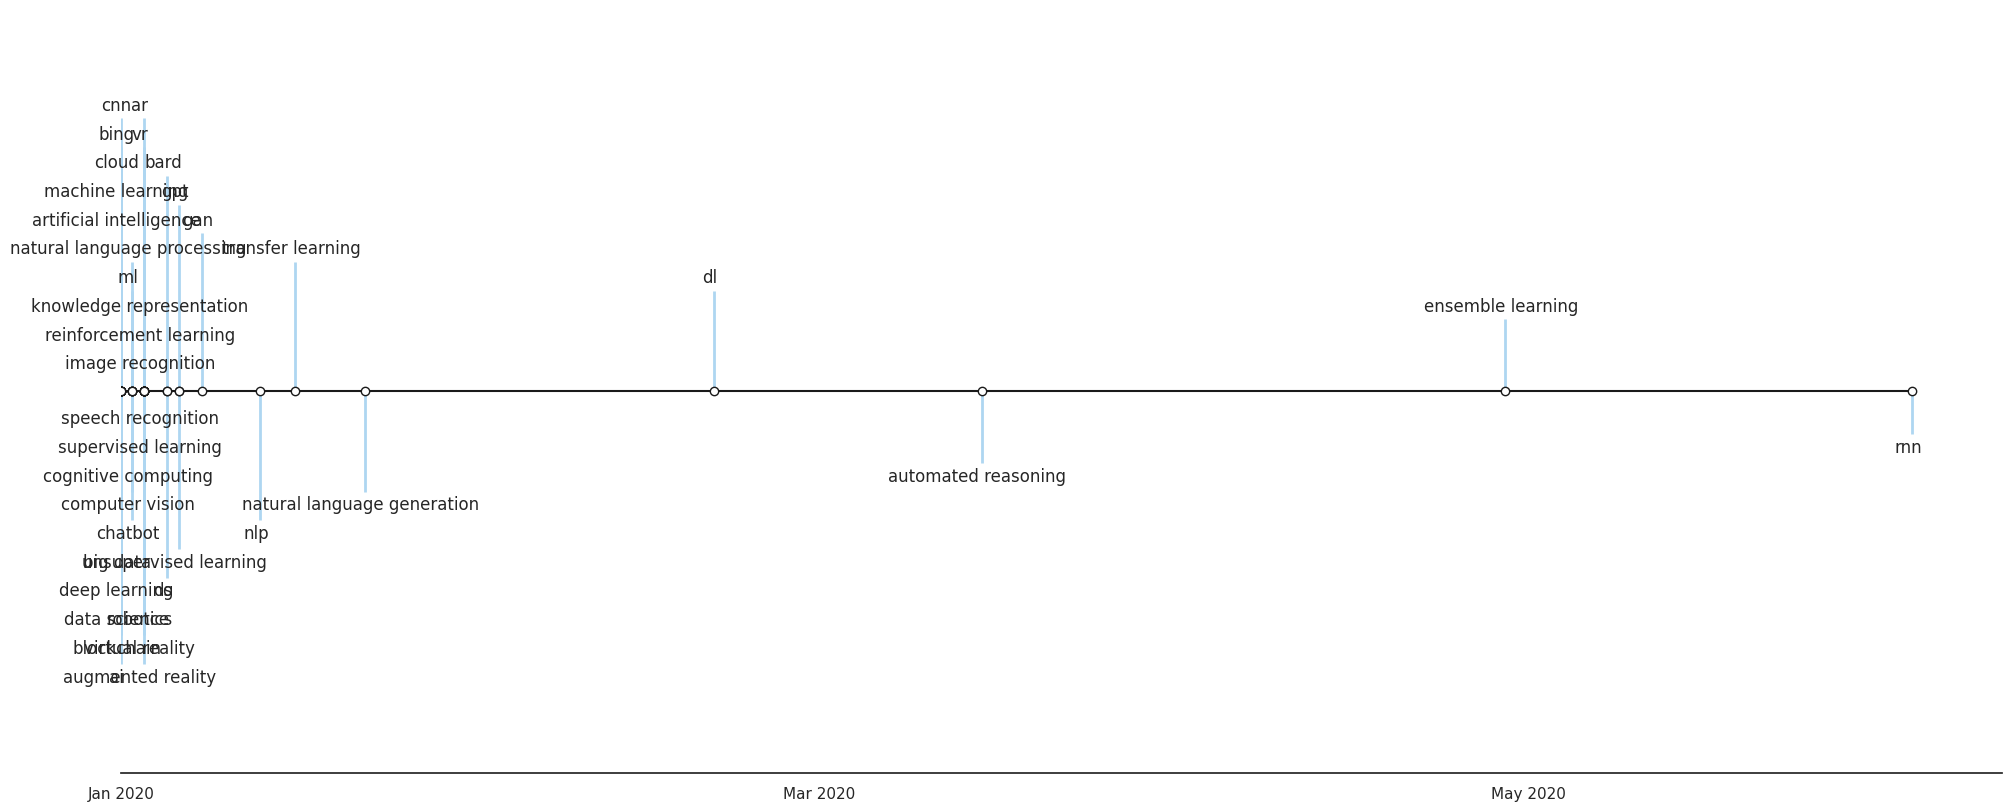

In [59]:
levels = np.tile([-19,19,-17,17,-15,15,-13,13,-11,11,-9,9,-7,7,-5,5,-3,3,-1,1],
                 int(np.ceil(len(dates)/20)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)

ax.vlines(dates, 0, levels, color="#AED6F1", linewidth=2)  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# Annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l > 0 else "top")

# Format x-axis with every other month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_xlim(left=mdates.date2num(pd.Timestamp("2020-01-01")))

plt.setp(ax.get_xticklabels(), ha="center")

# Remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(x=0.05, y=0.2)
plt.show()


In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html

# Choose some nice levels
levels = np.tile([-19,19,-17,17,-15,15,-13,13,-11,11,-9,9,-7,7,-5,5,-3,3,-1,1],
                 int(np.ceil(len(dates)/20)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(20, 8), layout="constrained")

ax.vlines(dates, 0, levels, color="#AED6F1", linewidth=2)  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# Annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l > 0 else "top")

# Format x-axis with 4-month intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax.get_xticklabels(), ha="center")

# Remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(x=0.05, y=0.2)
plt.show()

### Targeted sentiment

#### People

In [25]:
def flatten_nested_list(nested_list):
    # Flatten the nested list into a single list
    return list(chain(*nested_list))

In [26]:
# Create separate DataFrames for each sentiment label
tb_positive_peo_nested_list = sample_df.loc[sample_df['sentiment_vader'] == 'positive','top_peo'].tolist()
tb_negative_peo_nested_list = sample_df.loc[sample_df['sentiment_vader'] == 'negative','top_peo'].tolist()

# Flatten the nested list into a single list
tb_positive_peo_single_list = flatten_nested_list(tb_positive_peo_nested_list)
tb_negative_peo_single_list = flatten_nested_list(tb_negative_peo_nested_list)

# Concatenate the text data for each sentiment label into separate strings
tb_positive_peo_text = ' '.join(tb_positive_peo_single_list)
tb_negative_peo_text = ' '.join(tb_positive_peo_single_list)

# Create WordCloud objects for each sentiment label
tb_positive_peo_wordcloud = WordCloud(background_color='white').generate(tb_positive_peo_text)
tb_negative_peo_wordcloud = WordCloud(background_color='white').generate(tb_negative_peo_text)


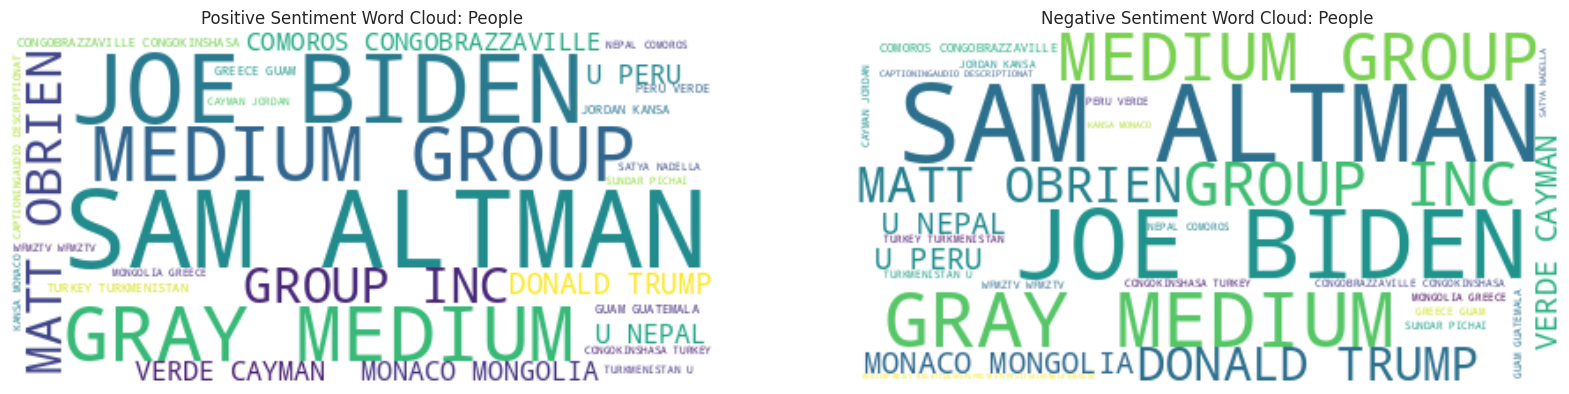

In [27]:
# Plot the word clouds
plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
plt.imshow(tb_positive_peo_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud: People')

plt.subplot(1, 2, 2)
plt.imshow(tb_negative_peo_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud: People')

plt.show()

#### Organization

In [29]:
# Create separate DataFrames for each sentiment label
tb_positive_org_nested_list = sample_df.loc[sample_df['sentiment_vader'] == 'positive','top_org'].tolist()
tb_negative_org_nested_list = sample_df.loc[sample_df['sentiment_vader'] == 'negative','top_org'].tolist()

# Flatten the nested list into a single list
tb_positive_org_single_list = flatten_nested_list(tb_positive_org_nested_list)
tb_negative_org_single_list = flatten_nested_list(tb_negative_org_nested_list)

# Concatenate the text data for each sentiment label into separate strings
tb_positive_org_text = ' '.join(tb_positive_org_single_list)
tb_negative_org_text = ' '.join(tb_positive_org_single_list)

# Create WordCloud objects for each sentiment label
tb_positive_org_wordcloud = WordCloud(background_color='white').generate(tb_positive_org_text)
tb_negative_org_wordcloud = WordCloud(background_color='white').generate(tb_negative_org_text)

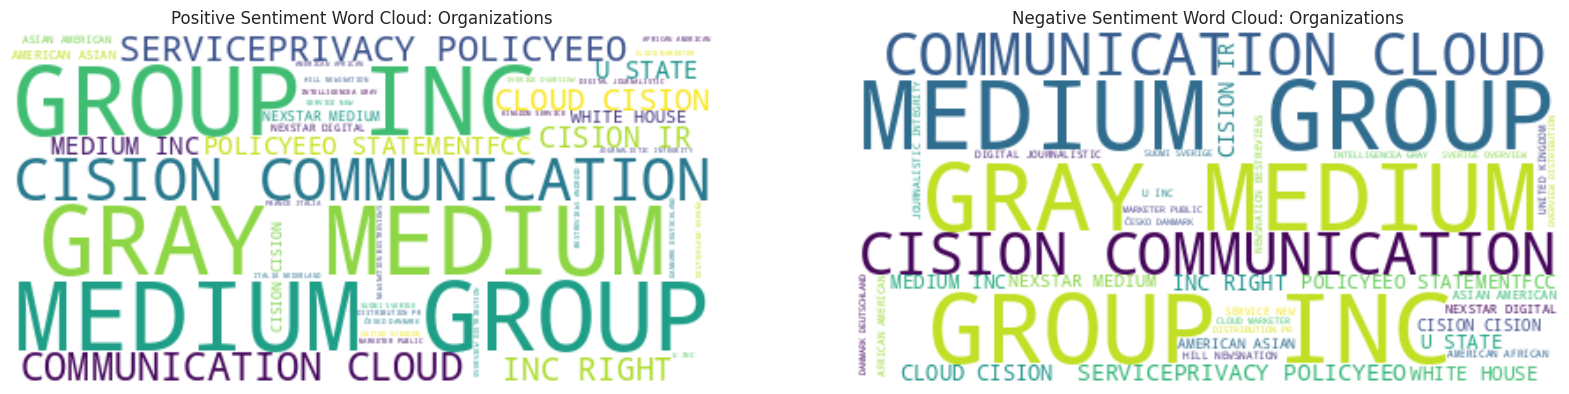

In [30]:
# Plot the word clouds
plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
plt.imshow(tb_positive_org_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud: Organizations')

plt.subplot(1, 2, 2)
plt.imshow(tb_negative_org_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud: Organizations')

plt.show()

In [31]:
# Explode the list column to create multiple rows
tb_peo_sentiment_df = sample_df.explode('top_peo')
tb_peo_sentiment_df = tb_peo_sentiment_df[['top_peo','sentiment_vader']]
tb_peo_sentiment_df = tb_peo_sentiment_df[tb_peo_sentiment_df['top_peo'] != '']
#tb_peo_sentiment_df.dropna(subset='top_peo', inplace=True, ignore_index=True)

tb_org_sentiment_df = sample_df.explode('top_org')
tb_org_sentiment_df = tb_org_sentiment_df[['top_org','sentiment_vader']]
tb_org_sentiment_df = tb_org_sentiment_df[tb_org_sentiment_df['top_org'] != '']
#tb_org_sentiment_df.dropna(subset='top_org', inplace=True, ignore_index=True)

# Group the data by target entity
tb_peo_sentiment_counts = tb_peo_sentiment_df.groupby(['top_peo','sentiment_vader']).size().reset_index(name='count')
tb_peo_sentiment_pivot = tb_peo_sentiment_counts.pivot_table(
    values='count', index='top_peo', columns='sentiment_vader', aggfunc='sum', margins=True, margins_name='Total')
tb_peo_sentiment_pivot = tb_peo_sentiment_pivot.drop('Total', axis=0).reset_index()
tb_peo_sentiment_pivot.sort_values(by=['Total', 'top_peo'], ascending=[False, True], inplace=True, ignore_index=True)

tb_org_sentiment_counts = tb_org_sentiment_df.groupby(['top_org','sentiment_vader']).size().reset_index(name='count')
tb_org_sentiment_pivot = tb_org_sentiment_counts.pivot_table(
    values='count', index='top_org', columns='sentiment_vader', aggfunc='sum', margins=True, margins_name='Total')
tb_org_sentiment_pivot = tb_org_sentiment_pivot.drop('Total', axis=0).reset_index()
tb_org_sentiment_pivot.sort_values(by=['Total', 'top_org'], ascending=[False, True], inplace=True, ignore_index=True)

In [32]:
tb_peo_sentiment_pivot = tb_peo_sentiment_pivot.head()
tb_peo_sentiment_pivot

sentiment_vader,top_peo,negative,neutral,positive,Total
0,SAM ALTMAN,294.0,6.0,2202.0,2502
1,BIDEN,231.0,7.0,1604.0,1842
2,JOE BIDEN,200.0,8.0,1325.0,1533
3,DONALD TRUMP,280.0,3.0,1031.0,1314
4,MONACO MONGOLIA,6.0,NaN,993.0,999


In [33]:
tb_org_sentiment_pivot = tb_org_sentiment_pivot.head()
tb_org_sentiment_pivot

sentiment_vader,top_org,negative,neutral,positive,Total
0,CHATGPT,1262.0,28.0,14290.0,15580
1,MICROSOFT,460.0,8.0,7022.0,7490
2,IBM,43.0,2.0,6462.0,6507
3,ANDROID,472.0,14.0,5545.0,6031
4,GOOGLE,453.0,17.0,4663.0,5133


<ipython-input-34-ffbaa72f805d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)
<ipython-input-34-ffbaa72f805d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)


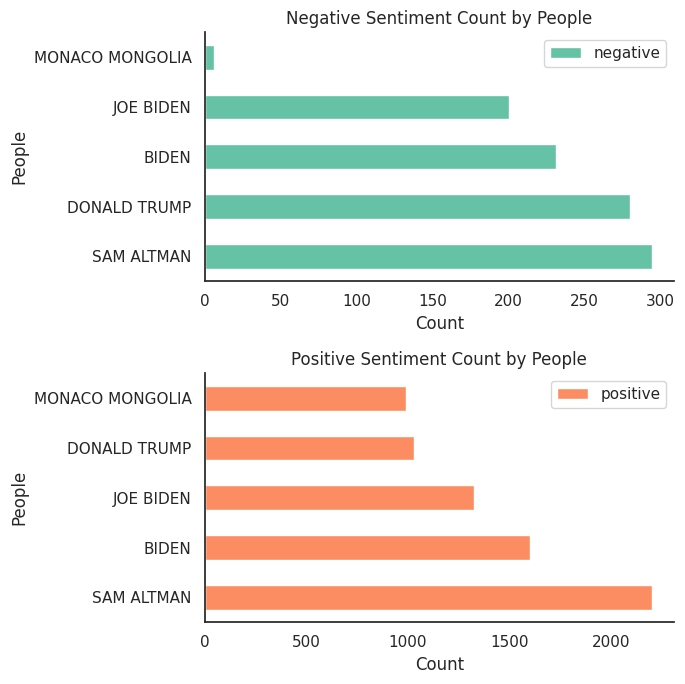

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

for i, col in enumerate(['negative', 'positive']):
    sub_plot = tb_peo_sentiment_pivot[['top_peo', col]]
    sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)

    ax = axes[i]
    sub_plot.head(10).plot(x='top_peo', y=col, kind='barh', ax=ax, color=sns.color_palette("Set2")[i])
    ax.set_title(f'{col.capitalize()} Sentiment Count by People')
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_xlabel('Count')
    ax.set_ylabel('People')

plt.tight_layout()
sns.despine()

plt.show()

<ipython-input-35-b92b3994b73e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)
<ipython-input-35-b92b3994b73e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)


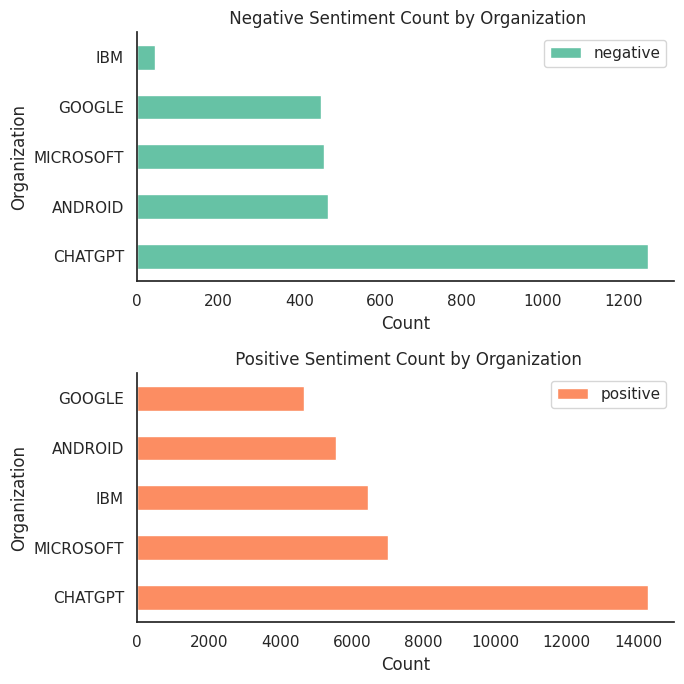

In [35]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

for i, col in enumerate(['negative', 'positive']):
    sub_plot = tb_org_sentiment_pivot[['top_org', col]]
    sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)

    ax = axes[i]
    sub_plot.head(10).plot(x='top_org', y=col, kind='barh', ax=ax, color=sns.color_palette("Set2")[i])
    ax.set_title(f' {col.capitalize()} Sentiment Count by Organization')
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_xlabel('Count')
    ax.set_ylabel('Organization')

plt.tight_layout()
sns.despine()

plt.show()